In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import tf2lib as tl
import tf2gan as gan
import DLlib as dl
import pylib as py
import wflib as wf
import data

import matplotlib.pyplot as plt
from itertools import cycle

In [2]:
dataset_dir = '../datasets/'
dataset_hdf5_1 = 'Bip_NRef_384_complex_2D.hdf5'
valX, valY, TE = data.load_hdf5(dataset_dir, dataset_hdf5_1, ech_idx=24, te_data=True, MEBCRN=True)

#valX = valX[:,:,:,::8,:]
#valY = valY[:,:,:,::8,:]

hgt = valX.shape[2]
wdt = valX.shape[3]

A_B_dataset_val = tf.data.Dataset.from_tensor_slices((valX,valY, TE)).batch(1)
val_iter = cycle(A_B_dataset_val)

fm_sc = 300.0
r2_sc = 200.0

In [3]:
# Create VET-Net and load weights
experiment_dir = py.join('output','TEaug-300')
args = py.args_from_yaml(py.join(experiment_dir, 'settings.yml'))

input_shape = (None,None,None,2)
G_A2B = dl.PM_Generator(input_shape=input_shape, te_input=args.te_input, te_shape=(None,), filters=args.n_G_filters)
tl.Checkpoint(dict(G_A2B=G_A2B), py.join(experiment_dir, 'checkpoints')).restore()


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002061CB561F0> and <tensorflow.python.keras.layers.core.TFOpLambda object at 0x000002061CB560D0>).

Two checkpoint references resolved to different objects (<tensorflow_addons.layers.normalizations.InstanceNormalization object at 0x000002061CB11610> and <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002061CB56520>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002057012F4F0> and <tensorflow_addons.layers.normalizations.InstanceNormalization object at 0x000002061CB11610>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent.RNN object at 0x000002061CAB5C40> and <tensorflow.python.keras.layers.core.Lambda object at 0x000002061CB02F70>).

Two checkpoint references resolved to different objects (<tensorflow_addons.laye

In [4]:
# Sample function
@tf.function
def sample(A, TE):
    A2B_PM = G_A2B([A,TE], training=False)
    A2B_PM = tf.where(A[:,:1,:,:,:]!=0.0,A2B_PM,0.0)
    A2B_WF = wf.get_rho(A, A2B_PM, field=args.field, te=TE)
    A2B = tf.concat([A2B_WF,A2B_PM],axis=1)
    return A2B

def test(A, TE=None):
    A2B = sample(A, TE)
    return A2B

In [23]:
A, B, TE = next(val_iter)

A = A[:,::2,...]
TE = TE[:,::2,...]
print(np.squeeze(np.round(TE*1e3,1)))

A2B = test(A, TE)

[1.3 3.5 5.7]


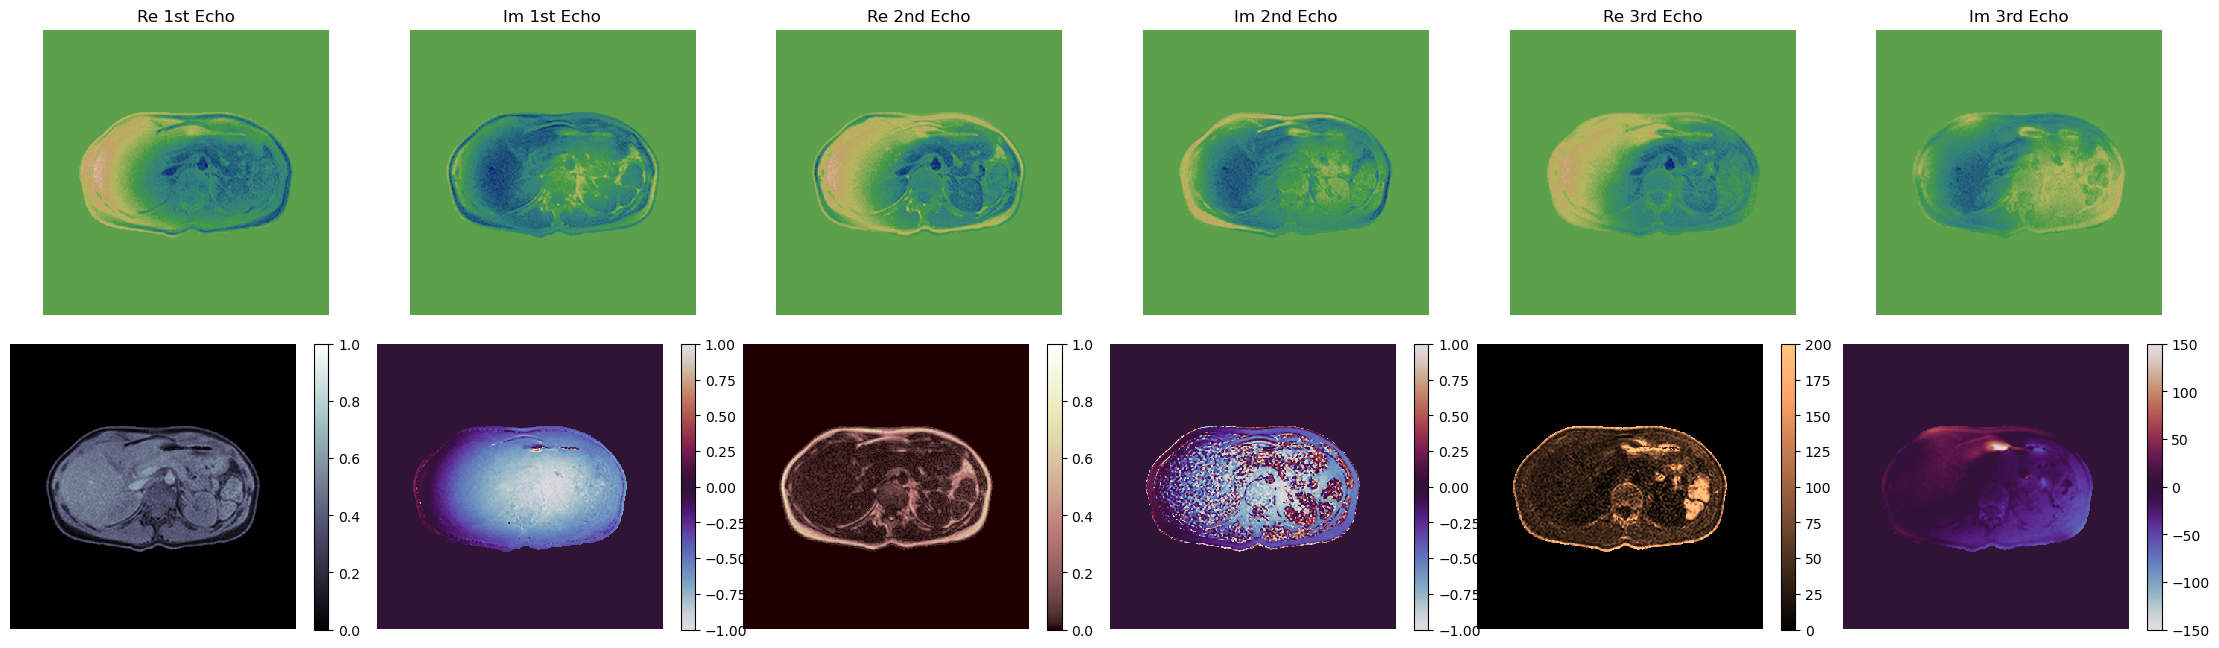

In [24]:
fig, axs = plt.subplots(figsize=(22, 6), nrows=2, ncols=6)

# Recon MR images at each echo
re_ech1 = np.squeeze(A[:,0,:,:,0])
re_ech2 = np.squeeze(A[:,1,:,:,0])
re_ech3 = np.squeeze(A[:,2,:,:,0])
im_ech1 = np.squeeze(A[:,0,:,:,1])
im_ech2 = np.squeeze(A[:,1,:,:,1])
im_ech3 = np.squeeze(A[:,2,:,:,1])

# Acquisitions in the first row
acq_ech1 = axs[0,0].imshow(re_ech1, cmap='gist_earth',
                      interpolation='none', vmin=-1, vmax=1)
axs[0,0].set_title('Re 1st Echo')
axs[0,0].axis('off')
acq_ech2 = axs[0,1].imshow(im_ech1, cmap='gist_earth',
                      interpolation='none', vmin=-1, vmax=1)
axs[0,1].set_title('Im 1st Echo')
axs[0,1].axis('off')
acq_ech3 = axs[0,2].imshow(re_ech2, cmap='gist_earth',
                          interpolation='none', vmin=-1, vmax=1)
axs[0,2].set_title('Re 2nd Echo')
axs[0,2].axis('off')
acq_ech4 = axs[0,3].imshow(im_ech2, cmap='gist_earth',
                          interpolation='none', vmin=-1, vmax=1)
axs[0,3].set_title('Im 2nd Echo')
axs[0,3].axis('off')
acq_ech5 = axs[0,4].imshow(re_ech3, cmap='gist_earth',
                          interpolation='none', vmin=-1, vmax=1)
axs[0,4].set_title('Re 3rd Echo')
axs[0,4].axis('off')
acq_ech6 = axs[0,5].imshow(im_ech3, cmap='gist_earth',
                          interpolation='none', vmin=-1, vmax=1)
axs[0,5].set_title('Im 3rd Echo')
axs[0,5].axis('off')

# A2B maps in the second row
w_m_aux = np.squeeze(np.abs(tf.complex(A2B[:,0,:,:,0],A2B[:,0,:,:,1])))
w_p_aux = np.squeeze(np.arctan2(A2B[:,0,:,:,1],A2B[:,0,:,:,0]))/np.pi
f_m_aux = np.squeeze(np.abs(tf.complex(A2B[:,1,:,:,0],A2B[:,1,:,:,1])))
f_p_aux = np.squeeze(np.arctan2(A2B[:,1,:,:,1],A2B[:,1,:,:,0]))/np.pi
r2_aux = np.squeeze(A2B[:,2,:,:,1])
field_aux = np.squeeze(A2B[:,2,:,:,0])

W_ok =  axs[1,0].imshow(w_m_aux, cmap='bone',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(W_ok, ax=axs[1,0])
axs[1,0].axis('off')

Wp_ok =  axs[1,1].imshow(w_p_aux, cmap='twilight',
                        interpolation='none', vmin=-1, vmax=1)
fig.colorbar(Wp_ok, ax=axs[1,1])
axs[1,1].axis('off')

F_ok =  axs[1,2].imshow(f_m_aux, cmap='pink',
                        interpolation='none', vmin=0, vmax=1)
fig.colorbar(F_ok, ax=axs[1,2])
axs[1,2].axis('off')

Fp_ok =  axs[1,3].imshow(f_p_aux, cmap='twilight',
                        interpolation='none', vmin=-1, vmax=1)
fig.colorbar(Fp_ok, ax=axs[1,3])
axs[1,3].axis('off')

r2_ok = axs[1,4].imshow(r2_aux*r2_sc, cmap='copper',
                        interpolation='none', vmin=0, vmax=r2_sc)
fig.colorbar(r2_ok, ax=axs[1,4])
axs[1,4].axis('off')

field_ok =  axs[1,5].imshow(field_aux*fm_sc, cmap='twilight',
                            interpolation='none', vmin=-fm_sc/2, vmax=fm_sc/2)
fig.colorbar(field_ok, ax=axs[1,5])
axs[1,5].axis('off')

plt.subplots_adjust(top=1,bottom=0,right=1,left=0,hspace=0.1,wspace=0)
tl.make_space_above(axs,topmargin=0.8)
plt.show()